In [75]:
%pylab inline
import os.path as op
import sys
import os

import json
import skimage.color
import skimage.filters
import morphsnakes as ms
import io3d.datasets


Populating the interactive namespace from numpy and matplotlib


In [76]:
pth = op.abspath("..")
sys.path.insert(0, pth)
import scaffan
import scaffan.annotation
import scaffan.image as scim
scaffan.image.import_openslide()

In [77]:
pth = op.expanduser(r"~\Downloads\openslide\openslide-win64\bin")
# pth = op.expanduser(r"~\projects\scaffan\devel\knihovny")
# pth = op.expanduser(r"~\Miniconda3\envs\lisa36\Library\bin")
sys.path.insert(0, pth)
orig_PATH = os.environ["PATH"]
os.environ["PATH"] = pth + ";" + os.environ["PATH"]
import openslide as opsl

In [78]:
import scaffan.annotation as scan
slices_dir = io3d.datasets.join_path("scaffold/Hamamatsu", get_root=True)
datapath = r"e:data/scaffold/Hamamatsu/PIG-008_P008 LL-P_HE_parenchyme perif..ndpi"
annotations = scan.read_annotations(datapath)

In [79]:

from scaffan.annotation import adjust_xy_to_image_view, adjust_to_image_view, annotations_to_px
from scaffan.image import get_offset_px, get_pixelsize

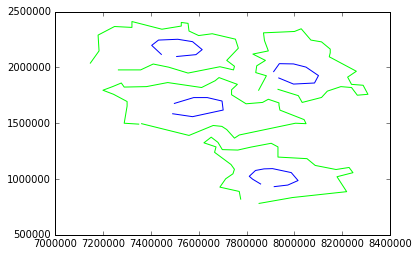

In [80]:
scan.plot_annotations(annotations)

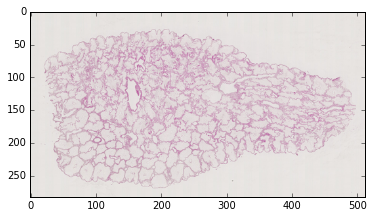

In [81]:
pth = r"E:/data/scaffold/Hamamatsu/PIG-008_P008 LL-P_HE_parenchyme perif..ndpi"
imsl = opsl.OpenSlide(pth)
imthumb = imsl.get_thumbnail((512, 512))

plt.imshow(imthumb)

In [82]:
pm = imsl.properties
list(pm.keys())

['hamamatsu.AHEX[0]',
 'hamamatsu.AHEX[0].fluorescence',
 'hamamatsu.AHEX[0].ploidy',
 'hamamatsu.AHEX[1]',
 'hamamatsu.AHEX[1].fluorescence',
 'hamamatsu.AHEX[1].ploidy',
 'hamamatsu.AHEX[2]',
 'hamamatsu.AHEX[2].fluorescence',
 'hamamatsu.AHEX[2].ploidy',
 'hamamatsu.Created',
 'hamamatsu.MHLN[0].24bit',
 'hamamatsu.MHLN[0].36bit',
 'hamamatsu.MHLN[1].24bit',
 'hamamatsu.MHLN[1].36bit',
 'hamamatsu.MHLN[2].24bit',
 'hamamatsu.MHLN[2].36bit',
 'hamamatsu.Macro.S/N',
 'hamamatsu.NDP.S/N',
 'hamamatsu.Objective.Lens.Magnificant',
 'hamamatsu.PSHV',
 'hamamatsu.PSHV.10x',
 'hamamatsu.PSHV.40x',
 'hamamatsu.PSHV.ploidy',
 'hamamatsu.PSHV.ploidy.10x',
 'hamamatsu.Product',
 'hamamatsu.Reference',
 'hamamatsu.SourceLens',
 'hamamatsu.Updated',
 'hamamatsu.XOffsetFromSlideCentre',
 'hamamatsu.YOffsetFromSlideCentre',
 'hamamatsu.YRNP[0]',
 'hamamatsu.YRNP[1]',
 'hamamatsu.YRNP[2]',
 'hamamatsu.calibration.version',
 'hamamatsu.ccd.height',
 'hamamatsu.ccd.width',
 'hamamatsu.ccd.width.ploidy

In [83]:
resolution_unit = pm.get("tiff.ResolutionUnit")
resolution_x= pm.get("tiff.XResolution")
resolution_y= pm.get("tiff.YResolution")
print("Resolution {}x{} pixels/{}".format(resolution_x, resolution_y, resolution_unit))
pixelsize = [10./float(resolution_x), 10./float(resolution_y)]
pixelunit = "mm"
print("pixelsize {} {}".format(pixelsize, pixelunit))

Resolution 44005x43953 pixels/centimeter
pixelsize [0.00022724690376093625, 0.00022751575546606603] mm


In [84]:

# def get_pixelsize(imsl):
#     pm = imsl.properties
#     resolution_unit = pm.get("tiff.ResolutionUnit")
#     resolution_x= pm.get("tiff.XResolution")
#     resolution_y= pm.get("tiff.YResolution")
# #     print("Resolution {}x{} pixels/{}".format(resolution_x, resolution_y, resolution_unit))
#     pixelsize = [10./float(resolution_x), 10./float(resolution_y)]
#     pixelunit = "mm"
#     return pixelsize, pixelunit
    
    

In [85]:
imsl.dimensions * np.asarray(pixelsize)

array([ 20.47767299,  11.35758651])

In [86]:
imsl.dimensions

(90112, 49920)

# Measure lobulus in pixels

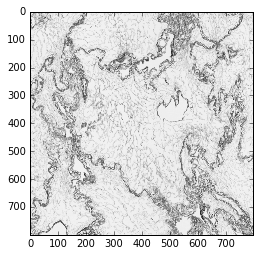

In [87]:
level = 3
imgr = scim.get_image_with_center(imsl, [22000,19000], level=level)
plt.imshow(imgr, cmap="gray")

In [88]:
level_pixelsize = imsl.level_downsamples[level] * np.asarray(pixelsize)
level_pixelsize

array([ 0.00181798,  0.00182013])

In [89]:
image_size_mm = imgr.shape * level_pixelsize
image_size_mm

array([ 1.45438018,  1.45610083])

# Localization of offset

In [90]:
offset = np.asarray((int(pm['hamamatsu.XOffsetFromSlideCentre']), int(pm['hamamatsu.YOffsetFromSlideCentre'])))
offset


array([7164983,  671863])

In [91]:

offset_mm = offset * 0.000001
offset_mm

array([ 7.164983,  0.671863])

In [92]:
offset_from_center_px = offset_mm / pixelsize
offset_from_center_px

array([ 31529.5076915,   2953.0394439])

In [93]:
im_center_px = np.asarray(imsl.dimensions) / 2.
im_center_px


array([ 45056.,  24960.])

In [94]:
offset_px = im_center_px - offset_from_center_px 
offset_px

array([ 13526.4923085,  22006.9605561])

In [95]:
offset_px.astype(np.int)

array([13526, 22006])

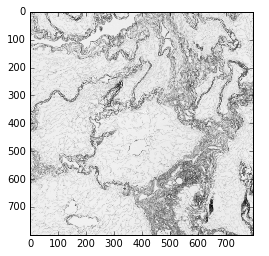

In [96]:
imgr = scim.get_image_with_center(imsl, offset_px.astype(np.int), level=3)
plt.imshow(imgr, cmap="gray")

# Draw into image

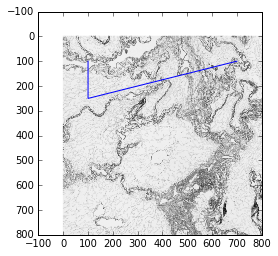

In [97]:
imgr = scim.get_image_with_center(imsl, offset_px.astype(np.int), level=3)
plt.imshow(imgr, cmap="gray")
plt.plot([100, 100, 700], [100, 250,100])

In [98]:
# def get_offset_px(imsl): 
    
#     offset = np.asarray((int(pm['hamamatsu.XOffsetFromSlideCentre']), int(pm['hamamatsu.YOffsetFromSlideCentre'])))
#     offset_mm = offset * 0.000001
#     offset_from_center_px = offset_mm / pixelsize
#     im_center_px = np.asarray(imsl.dimensions) / 2.
#     offset_px = im_center_px - offset_from_center_px 
#     return offset_px

In [99]:
def annotations_to_px(imsl, annotations):
    offset_px = get_offset_px(imsl)
    for annotation in annotations:
    
        x_nm = np.asarray(annotation['x'])
        y_nm = np.asarray(annotation['y'])
        x_mm = x_nm * 0.000001
        y_mm = y_nm * 0.000001
        x_px = x_mm / pixelsize[0] + offset_px[0]
        y_px = y_mm / pixelsize[1] + offset_px[1]
        annotation["x_nm"] = x_nm
        annotation["y_nm"] = y_nm
        annotation["x_mm"] = x_mm
        annotation["y_mm"] = y_mm
        annotation["x_px"] = x_px
        annotation["y_px"] = y_px
    return annotations


In [100]:
annotations = annotations_to_px(imsl, annotations)

In [101]:
# def adjust_xy_to_image_view(imsl, x_px, y_px, center, level, size):
    
#     x_px_view = ((x_px - center[0]) / imsl.level_downsamples[level]) + (size[0] / 2)
#     y_px_view = ((y_px - center[1]) / imsl.level_downsamples[level]) + (size[1] / 2)
#     return x_px_view, y_px_view

In [102]:
# def adjust_to_image_view(imsl, annotations, center, level, size):
#     output = []
#     for annotation in annotations:
#         ann_out = copy.copy(annotation)
#         x_px_view, y_px_view = adjust_xy_to_image_view(imsl, annotation["x_px"], annotation["y_px"], center, level, size)
#         ann_out["view_x_px"] = x_px_view
#         ann_out["view_y_px"] = y_px_view
#         ann_out["view_center"] = center
#         ann_out["view_level"] = level
#         ann_out["view_size"] = size
#         output.append(ann_out)
        
#     return output

In [103]:
annotation = annotations[0]
x_px = annotation["x_px"]
y_px = annotation["y_px"]

annotation_center = np.array([np.mean(x_px), np.mean(y_px)]) 
im_size = np.array([400, 400])


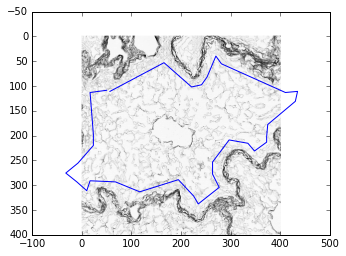

In [104]:

imgr = scim.get_image_with_center(imsl, annotation_center.astype(np.int), level=level, size=im_size)
plt.imshow(imgr, cmap="gray")
plt.plot(
    ((x_px - annotation_center[0]) / imsl.level_downsamples[level]) + (im_size[0] / 2),
    ((y_px - annotation_center[1]) / imsl.level_downsamples[level]) + (im_size[1] / 2),
)

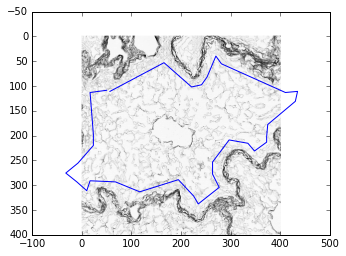

In [105]:

imgr = scim.get_image_with_center(imsl, annotation_center.astype(np.int), level=level, size=im_size)
plt.imshow(imgr, cmap="gray")
plt.plot(
    *adjust_xy_to_image_view(imsl, x_px, y_px, center=annotation_center, level=level, size=im_size)
)

In [106]:
annotations = annotations_to_px(imsl, annotations)
annotations = adjust_to_image_view(imsl, annotations, center=annotation_center, level=level, size=im_size)

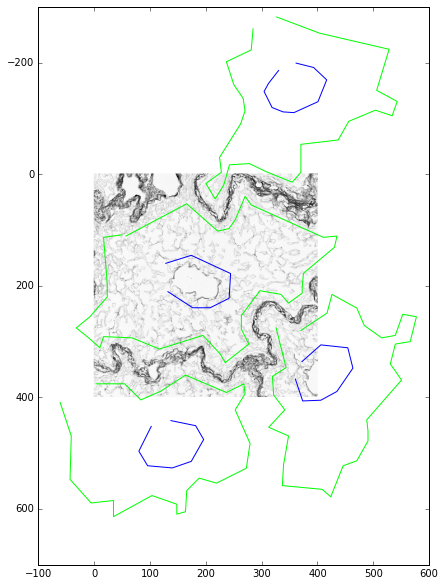

In [111]:

imgr = scim.get_image_with_center(imsl, annotation_center.astype(np.int), level=level, size=im_size)
plt.figure(figsize=(15, 10))
plt.imshow(imgr, cmap="gray")
# plt.plot(
#     *adjust_xy_to_image_view(imsl, x_px, y_px, center=annotation_center, level=level, size=im_size)
# )
scan.plot_annotations(annotations, x_key="view_x_px", y_key="view_y_px")

In [108]:
imsl.dimensions * np.array(pixelsize)

array([ 20.47767299,  11.35758651])